In [1]:
%reload_ext autoreload
%autoreload 2
%autosave 120
%matplotlib inline
import keras
import numpy as np, matplotlib.pyplot as plt
from os.path import join

Autosaving every 120 seconds


Using TensorFlow backend.


In [0]:
from scipy.ndimage.interpolation import shift
#!unzip data -d my_data

# New Section

# New Section

val :  (582, 81, 81, 3) 0/1 split 50.0 %
train :  (3316, 81, 81, 3) 0/1 split 50.0 %


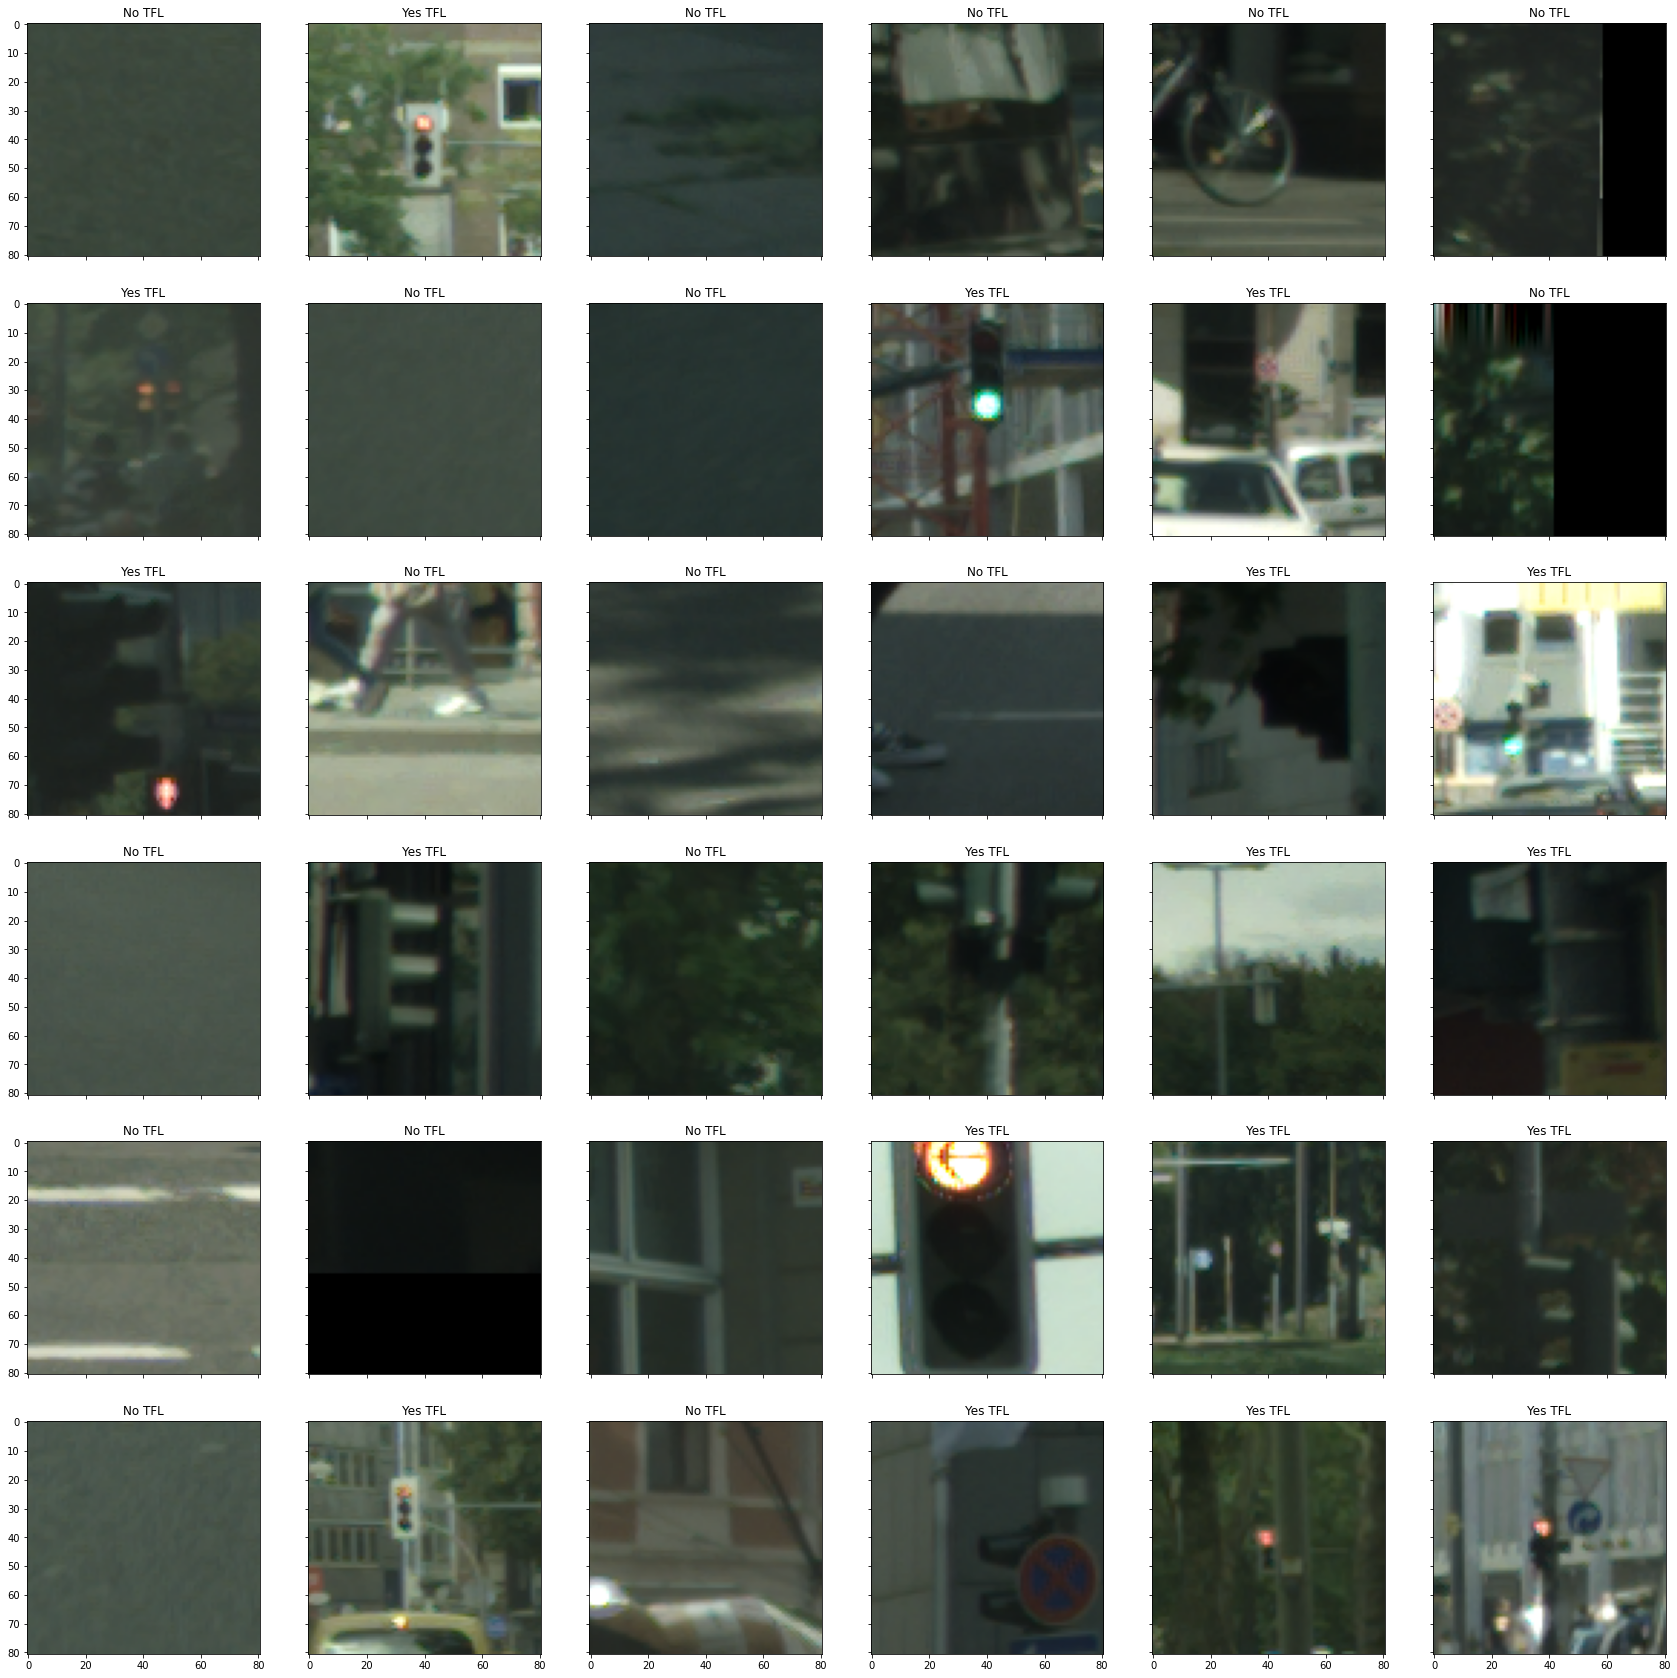

In [3]:
def load_tfl_data(data_dir, crop_shape=(81,81)):
    images = np.memmap(join(data_dir,'data.bin'),mode='r',dtype=np.uint8).reshape([-1]+list(crop_shape)+[3])
    labels = np.memmap(join(data_dir,'labels.bin'),mode='r',dtype=np.uint8)
    return {'images':images,'labels':labels}

def viz_my_data(images,labels, predictions=None, num=(5,5), labels2name= {0:'No TFL',1:'Yes TFL'}):
    assert images.shape[0] == labels.shape[0]
    assert predictions is None or predictions.shape[0] == images.shape[0]
    h = 5
    n = num[0]*num[1]
    ax = plt.subplots(num[0],num[1],figsize=(h*num[0],h*num[1]),gridspec_kw={'wspace':0.05},squeeze=False,sharex=True,sharey=True)[1]#.flatten()
    idxs = np.random.randint(0,images.shape[0],n)
    for i,idx in enumerate(idxs):
        ax.flatten()[i].imshow(images[idx])
        title = labels2name[labels[idx]]
        if predictions is not None : title += ' Prediction: {}'.format(labels2name[predictions[idx]])
        ax.flatten()[i].set_title(title)
    

root = '/content/my_data'  #this is the root for your val and train datasets
datasets = {
    'val':load_tfl_data(join(root,'val')),
    'train': load_tfl_data(join(root,'train')),
    }
for k,v in datasets.items():
    
    print ('{} :  {} 0/1 split {:.1f} %'.format(k,v['images'].shape, np.mean(v['labels']==1)*100))

viz_my_data(num=(6,6),**datasets['val'])   

/content


In [0]:
def shift_image(image, dx, dy):
   
    
    shifted_image = shift(image, [dx, dy, 0], cval=0, mode='constant')
    return shifted_image

In [5]:
!pip install -U scipy==1.2.0

Requirement already up-to-date: scipy==1.2.0 in /usr/local/lib/python3.6/dist-packages (1.2.0)


In [0]:
from scipy.misc import imsave

In [43]:
#from scipy.misc import imsave
train,val = datasets['train'],datasets['val']
x_train_shift = np.empty([13264,81,81,3])
y_train_augmented = np.empty([13264])
i = 0
for dx, dy in((1,0),(-1,0),(0,1),(0,-1)):
    for image, label in zip(train['images'],train['labels']):
        x_train_shift[i,:,:,:]=shift_image(image, dx, dy)
        y_train_augmented[i]=label
        if( label == 1):
          imsave(join('/content/data/train/Yes',str(i)+'.jpg'), x_train_shift[i,:,:,:])
        else:
          imsave(join('/content/data/train/No',str(i)+'.jpg'), x_train_shift[i,:,:,:])
        i = i+1

x_val_shift = np.empty([2328,81,81,3])
y_val_augmented = np.empty([2328])
i = 0
for dx, dy in((1,0),(-1,0),(0,1),(0,-1)):
    for image, label in zip(val['images'],val['labels']):
        x_val_shift[i,:,:,:]=shift_image(image, dx, dy)
        y_val_augmented[i]=label
        if( label == 1):
          imsave(join('/content/data/valid/Yes',str(i)+'.jpg'), x_train_shift[i,:,:,:])
        else:
          imsave(join('/content/data/valid/No',str(i)+'.jpg'), x_train_shift[i,:,:,:])
        i = i+1



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [40]:
import shutil
shutil.move("/content/data", "/usr/local/lib/python3.6/dist-packages/fastai")

'/usr/local/lib/python3.6/dist-packages/fastai/data'

In [0]:
from fastai.vision import *
from fastai.metrics import accuracy

In [35]:
path1

PosixPath('/content/data')

In [0]:
path1 = Path('/content/data')

In [0]:
data = ImageDataBunch.from_folder(path1)

In [0]:
bs = 64

In [0]:
class ArrayDataset(Dataset):
    "Sample numpy array dataset"
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.c = 2 # bi) nary label
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [13]:
x_train = x_train_shift.astype(float)
y_train = y_train_augmented.astype(float)

x_valid = x_val_shift.astype(float)
y_valid = y_val_augmented.astype(float)


#train_ds = TensorDataset(x_train, y_train)
#valid_ds = TensorDataset(x_valid, y_valid)
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
train_ds, valid_ds = ArrayDataset(x_train/255.0, y_train), ArrayDataset(x_valid/255.0, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=2, num_workers=1)
data.device

device(type='cuda')

In [58]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [59]:
learn.fit_one_cycle(12)

epoch,train_loss,valid_loss,accuracy,time
0,0.501945,0.309447,0.878007,00:30
1,0.352079,0.221999,0.913660,00:28
2,0.263057,0.162958,0.932131,00:28
3,0.206630,0.110749,0.958333,00:28
4,0.166609,0.075489,0.972079,00:28
5,0.131246,0.039202,0.985825,00:28
6,0.097086,0.026272,0.993986,00:28
7,0.085767,0.019951,0.993986,00:28
8,0.045779,0.009403,1.000000,00:28
9,0.039403,0.006437,1.000000,00:29


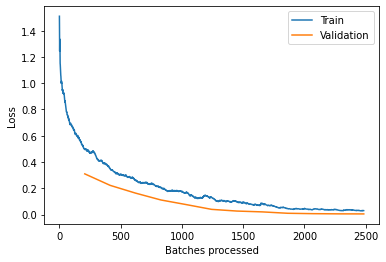

In [60]:
learn.recorder.